In [78]:
import torch
import numpy as np
from hysteresis.base import TorchHysteresis
from hysteresis.training import train_torch
from hysteresis.visualization import plot_hysteresis_density
import matplotlib.pyplot as plt

In [79]:
def get_data(fname):

    data = []
    with open(fname,'r') as f:
        f.readline()
        for line in f:
            temp = line.rstrip().split(' ')
            d = []
            for ele in temp:
                if ele != '':
                    d += [ele]
            data += [d]
    data = np.asfarray(data)
    return data

In [80]:
full_data = []
for ele in range(3,9):
    fname = f'D:/SLAC/hysteresis/magnet_characterization/strplt.ru{ele}'
    full_data += [get_data(fname)]
full_data = np.vstack(full_data)
print(full_data.shape)

# get real h, m
h = torch.tensor(full_data[:,1]).double()
m = torch.tensor(full_data[:,3]).double()

(187, 9)


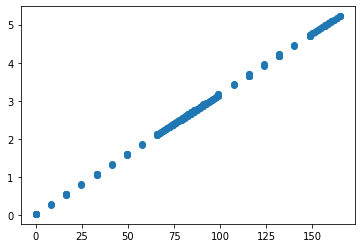

In [81]:
fig,ax = plt.subplots()
ax.plot(h, m,'o')

In [82]:

# normalize h, m
h = (h - torch.min(h)) / (torch.max(h) - torch.min(h))
m = ((m - torch.mean(m)) / (max(m) - min(m)))*2.0 - 1.0

slope = (torch.max(m) - torch.min(m)) / \
        (torch.max(h) - torch.min(h))
scale = torch.std(m - slope * h - torch.min(m)) ** -1

def transform_m(m):
    return (m - slope * h - torch.min(m)) * scale
m = transform_m(m)

n_train = 60
h_train = h[:n_train]
m_train = m[:n_train]

In [83]:
# fit using normal hysteresis model
H = TorchHysteresis(h_train, mesh_scale = 0.01, temp=1e-2)

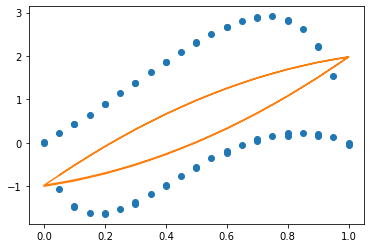

In [84]:
fig,ax = plt.subplots()
ax.plot(h_train, m_train,'o')
ax.plot(h_train, H.predict_magnetization_from_applied_fields().detach())

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
tensor(9.3787e-05, dtype=torch.float64)
tensor(9.3787e-05, dtype=torch.float64)
Parameter containing:
tensor([14.8860], dtype=torch.float64, requires_grad=True)
Parameter containing:
tensor([14.8934], dtype=torch.float64, requires_grad=True)


C:\Users\RYANRO~1\AppData\Local\Temp/ipykernel_12912/1438081651.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print(torch.min(torch.tensor(loss_trace)))


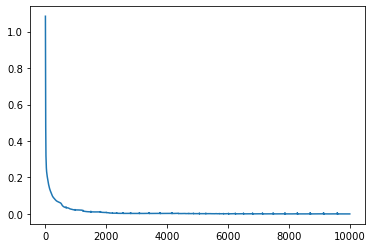

In [85]:
# train on data
loss_trace = train_torch(H, m_train, 10000, lr=0.1, atol=1e-8)
fig, ax = plt.subplots()
ax.plot(loss_trace)
print(loss_trace[-1])
print(torch.min(torch.tensor(loss_trace)))
print(H.offset)
print(H.scale)

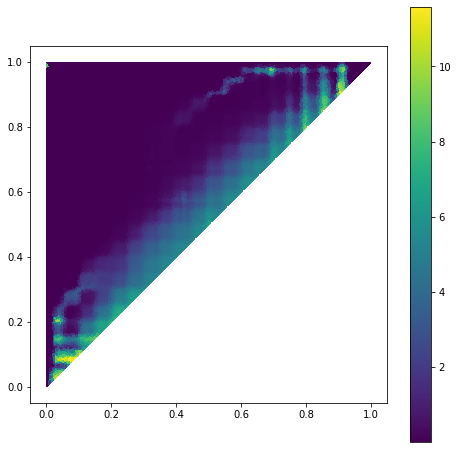

In [86]:
fig, ax = plot_hysteresis_density(H)
ax.set_aspect('equal')
fig.set_size_inches(8,8)

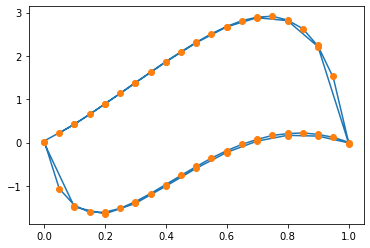

In [87]:
def fit(x):
    return 2.0*x - 1.0

fig, ax = plt.subplots()
m_pred = H.predict_magnetization_from_applied_fields()
ax.plot(h_train, m_pred.detach())
ax.plot(h_train, m_train,'o')


tensor(0.2114, dtype=torch.float64, grad_fn=<SqrtBackward>)


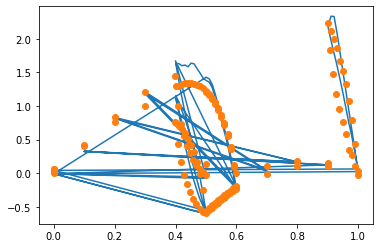

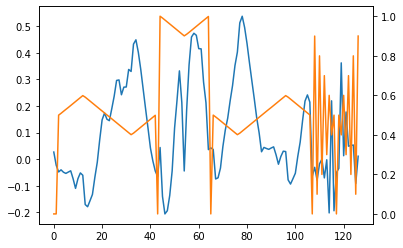

In [89]:
# plot prediction
fig2, ax2 = plt.subplots()
fig.set_size_inches(10,10)

m_future = H.predict_magnetization_future(h[n_train:])
ax2.plot(h[n_train:], m_future.detach())
ax2.plot(h[n_train:], m[n_train:],'o')

fig3, ax3 = plt.subplots()
ax3.plot(m_future.detach() - m[n_train:])
ax3b = ax3.twinx()
ax3b.plot(h[n_train:], 'C1')
print(torch.sqrt(torch.nn.MSELoss()(m_future, m[n_train:])))